In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [2]:
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X = faces.data      # shape: (400, 4096)
y = faces.target    # shape: (400,)
print("Data Shape:", X.shape, "Labels Shape:", y.shape)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Radhakrishna\scikit_learn_data
Data Shape: (400, 4096) Labels Shape: (400,)


In [3]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_index, test_index in sss.split(X, y):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

# Further split train_val into train and validation
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
for train_index, val_index in sss2.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")



Train size: 240, Validation size: 80, Test size: 80


In [4]:
n_clusters = 40   # try starting with 40 clusters (one per person)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred_clusters = kmeans.fit_predict(X)
print("K-Means cluster labels shape:", y_pred_clusters.shape)


K-Means cluster labels shape: (400,)


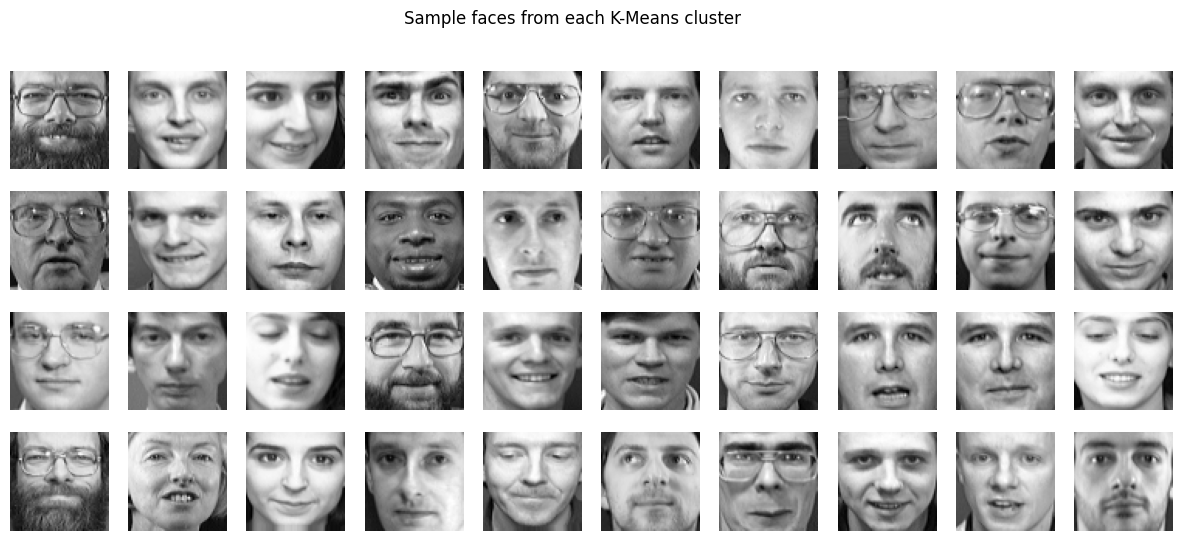

In [5]:
plt.figure(figsize=(15, 6))
for i in range(n_clusters):
    # Select images from cluster i
    cluster_faces = X[y_pred_clusters == i]
    if cluster_faces.shape[0] > 0:
        face = cluster_faces[0]
    else:
        face = kmeans.cluster_centers_[i]
    plt.subplot(4, 10, i + 1)
    plt.imshow(face.reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample faces from each K-Means cluster")
plt.show()


In [6]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
acc_val_original = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy (Original features): {acc_val_original:.4f}")


Validation accuracy (Original features): 0.9250


In [7]:
accuracies = []
n_clusters_range = range(10, 61, 10)
for n_clusters_dim in n_clusters_range:
    kmeans_dim = KMeans(n_clusters=n_clusters_dim, random_state=42)
    X_train_kmeans = kmeans_dim.fit_transform(X_train)
    X_val_kmeans = kmeans_dim.transform(X_val)
    clf_kmeans = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_kmeans.fit(X_train_kmeans, y_train)
    y_val_pred_kmeans = clf_kmeans.predict(X_val_kmeans)
    acc = accuracy_score(y_val, y_val_pred_kmeans)
    accuracies.append(acc)
    print(f"Clusters: {n_clusters_dim} | Validation Accuracy: {acc:.4f}")

best_acc = max(accuracies)
best_clusters = n_clusters_range[np.argmax(accuracies)]
print(f"\nBest accuracy with K-Means features: {best_acc:.4f} (Clusters: {best_clusters})")


Clusters: 10 | Validation Accuracy: 0.6000
Clusters: 20 | Validation Accuracy: 0.7000
Clusters: 30 | Validation Accuracy: 0.7750
Clusters: 40 | Validation Accuracy: 0.7750
Clusters: 50 | Validation Accuracy: 0.7625
Clusters: 60 | Validation Accuracy: 0.8250

Best accuracy with K-Means features: 0.8250 (Clusters: 60)


In [8]:
acc_combined = []
for n_clusters_dim in n_clusters_range:
    kmeans_dim = KMeans(n_clusters=n_clusters_dim, random_state=42)
    X_train_kmeans = kmeans_dim.fit_transform(X_train)
    X_val_kmeans = kmeans_dim.transform(X_val)
    # Append the reduced features to the original features
    X_train_combined = np.hstack([X_train, X_train_kmeans])
    X_val_combined = np.hstack([X_val, X_val_kmeans])
    clf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_combined.fit(X_train_combined, y_train)
    y_val_pred_combined = clf_combined.predict(X_val_combined)
    acc = accuracy_score(y_val, y_val_pred_combined)
    acc_combined.append(acc)
    print(f"Clusters: {n_clusters_dim} | Validation Accuracy (combined): {acc:.4f}")

best_acc_combined = max(acc_combined)
best_clusters_combined = n_clusters_range[np.argmax(acc_combined)]
print(f"\nBest accuracy (combined features): {best_acc_combined:.4f} (Clusters: {best_clusters_combined})")


Clusters: 10 | Validation Accuracy (combined): 0.9500
Clusters: 20 | Validation Accuracy (combined): 0.9250
Clusters: 30 | Validation Accuracy (combined): 0.9375
Clusters: 40 | Validation Accuracy (combined): 0.9375
Clusters: 50 | Validation Accuracy (combined): 0.9125
Clusters: 60 | Validation Accuracy (combined): 0.9375

Best accuracy (combined features): 0.9500 (Clusters: 10)


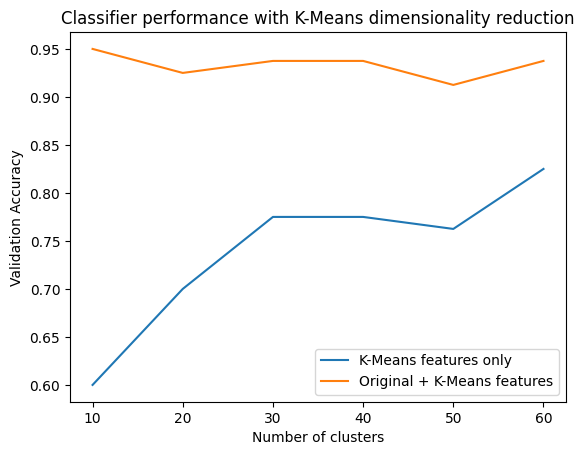

In [9]:
plt.plot(n_clusters_range, accuracies, label="K-Means features only")
plt.plot(n_clusters_range, acc_combined, label="Original + K-Means features")
plt.xlabel("Number of clusters")
plt.ylabel("Validation Accuracy")
plt.title("Classifier performance with K-Means dimensionality reduction")
plt.legend()
plt.show()
